In [1]:
import urllib.request
import requests
import pandas as pd
import seaborn as sns
import geopandas as gpd
import json
from matplotlib import pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from shapely.geometry import MultiPolygon, Polygon, Point

In [2]:
COMMUNES_FILE = 'data/communes-martinique.geojson'
AGRESTE_FILE = 'data/agreste-2020-martinique.csv'

In [3]:
gdf_mq = gpd.read_file(COMMUNES_FILE)
gdf_mq.code = gdf_mq.code.astype(int)
df = pd.read_csv(AGRESTE_FILE, encoding='iso-8859-1').rename(columns={'CODE_GEO': 'code'})
print(gdf_mq.code.dtype, df.code.dtype)

int64 int64


In [4]:
s = df.loc[(df.N122_MOD == 'Ensemble des exploitations') & (df.N110d_MOD == 'Toutes exploitations')][['code', 'ANNREF', 'VALEUR_EXTRAPOLEE', 'RA2020_001_DIM3_MOD']]
ss = (s.loc[(s.ANNREF == 2020) & (s.RA2020_001_DIM3_MOD =='Production brute standard (')].drop(columns=['ANNREF', 'RA2020_001_DIM3_MOD']).rename(columns={'VALEUR_EXTRAPOLEE' : 'valeur_2020'})
      .merge(s.loc[(s.ANNREF == 2010) & (s.RA2020_001_DIM3_MOD =='Production brute standard (')].drop(columns=['ANNREF', 'RA2020_001_DIM3_MOD']).rename(columns={'VALEUR_EXTRAPOLEE' : 'valeur_2010'}), on='code')
      .merge(s.loc[(s.ANNREF == 2020) & (s.RA2020_001_DIM3_MOD =='Superficie agricole utilisé')].drop(columns=['ANNREF', 'RA2020_001_DIM3_MOD']).rename(columns={'VALEUR_EXTRAPOLEE' : 'superficie_2020'}), on='code')
      .merge(s.loc[(s.ANNREF == 2010) & (s.RA2020_001_DIM3_MOD =='Superficie agricole utilisé')].drop(columns=['ANNREF', 'RA2020_001_DIM3_MOD']).rename(columns={'VALEUR_EXTRAPOLEE' : 'superficie_2010'}), on='code')
)
ss['v/s 2020'] = ss['valeur_2020'] / ss['superficie_2020']
ss['v/s 2010'] = ss['valeur_2010'] / ss['superficie_2010']

ss['evo_surface']= 100 * ss['superficie_2020'] / ss['superficie_2010'] - 100
ss['evo_v/s'] =  100 * ss['v/s 2020'] / ss['v/s 2010'] - 100

In [5]:
g = gdf_mq.merge(ss, on='code')

<AxesSubplot:>

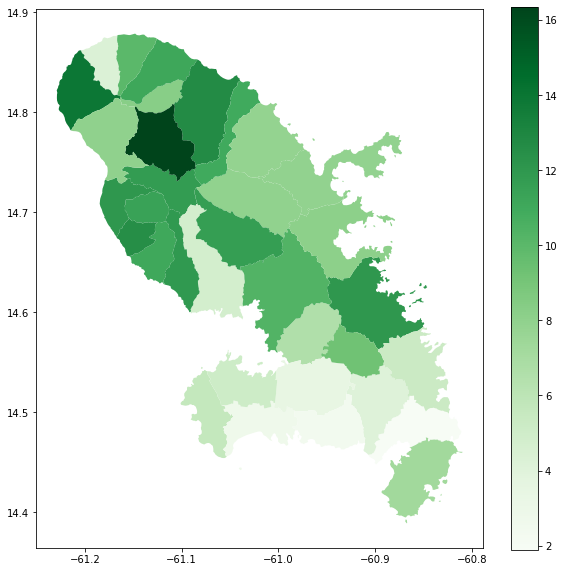

In [6]:
g.plot(column='v/s 2020', cmap='Greens', legend=True, figsize=(10,10))

Text(0.5, 1.0, 'k€/ha 2020')

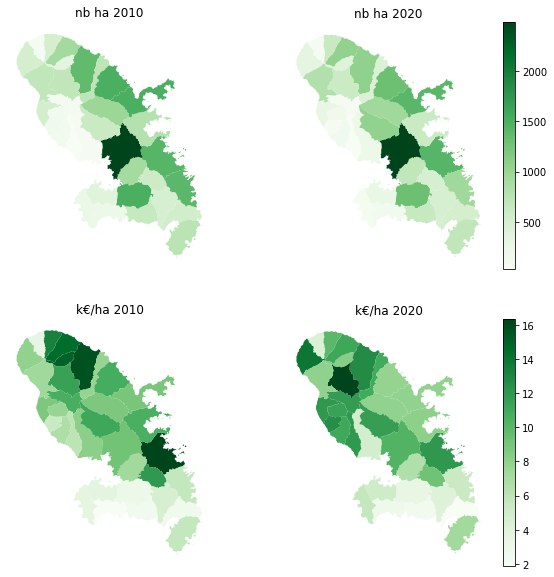

In [7]:

f, axes = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
g.plot(column='superficie_2010', cmap='Greens', ax=axes[0][0])
a = g.plot(column='superficie_2020', cmap='Greens', legend=True, ax=axes[0][1])
axes[0][0].axis('off')
axes[0][1].axis('off')
g.plot(column='v/s 2010', cmap='Greens', ax=axes[1][0])
g.plot(column='v/s 2020', cmap='Greens', legend=True, ax=axes[1][1])
axes[1][0].axis('off')
axes[1][1].axis('off')

axes[0][0].set_title('nb ha 2010')
axes[0][1].set_title('nb ha 2020')

axes[1][0].set_title('k€/ha 2010')
axes[1][1].set_title('k€/ha 2020')


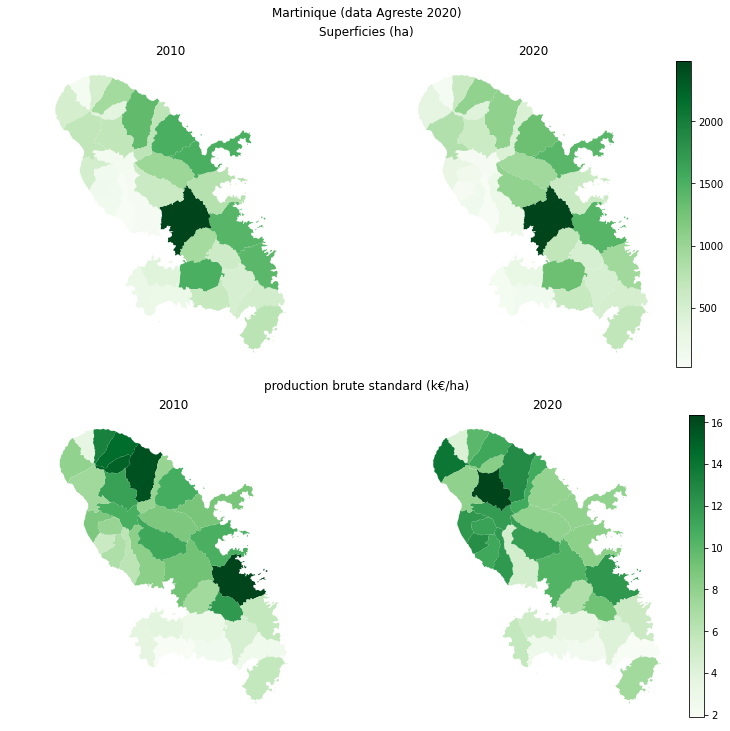

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(10,10))
fig.suptitle('Martinique (data Agreste 2020)')

r1, r2 = fig.subfigures(nrows=2, ncols=1)

r1.suptitle(f'Superficies (ha)')
r2.suptitle(f'production brute standard (k€/ha)')

axs1 = r1.subplots(nrows=1, ncols=2)
g.plot(column='superficie_2010', cmap='Greens', ax=axs1[0])
g.plot(column='superficie_2020', cmap='Greens', legend=True, ax=axs1[1])
axs1[0].set_title(f'2010')
axs1[1].set_title(f'2020')

axs2 = r2.subplots(nrows=1, ncols=2)
g.plot(column='v/s 2010', cmap='Greens', ax=axs2[0])
g.plot(column='v/s 2020', cmap='Greens', legend=True, ax=axs2[1])
axs2[0].set_title(f'2010')
axs2[1].set_title(f'2020')

for ax in list(axs1) + list(axs2):
    ax.axis('off')


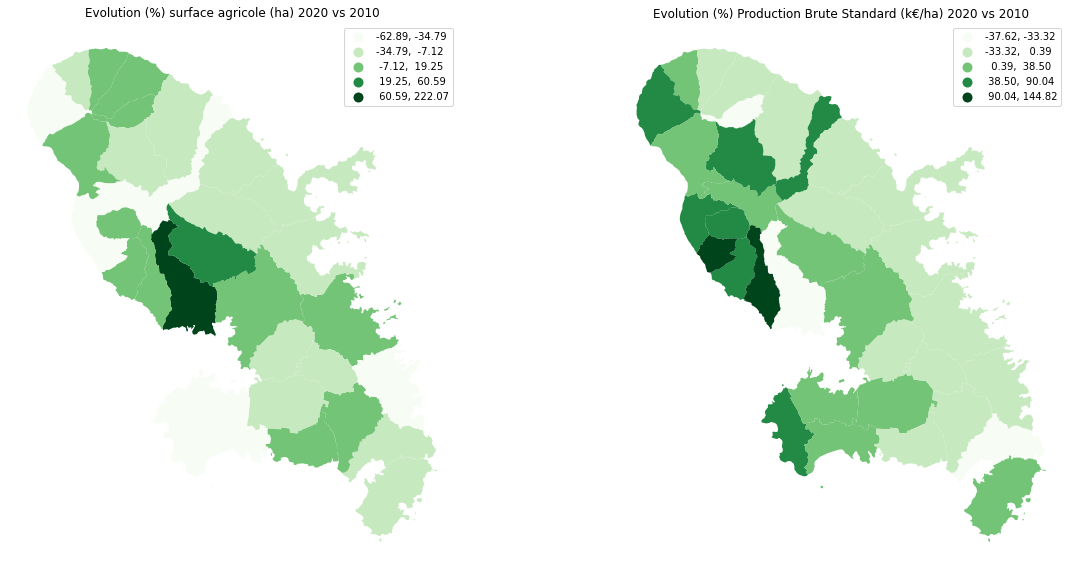

In [10]:
f, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=1)
g.plot(column='evo_surface', cmap='Greens', ax=axes[0], legend=True, scheme='natural_breaks',)
a = g.plot(column='evo_v/s', cmap='Greens', legend=True, ax=axes[1], scheme='natural_breaks',)
axes[0].axis('off')
axes[1].axis('off')
_ = axes[0].set_title('Evolution (%) surface agricole (ha) 2020 vs 2010')
_ = axes[1].set_title('Evolution (%) Production Brute Standard (k€/ha) 2020 vs 2010')

plt.savefig('output/2022-11-04.png', facecolor='white')